# Estimate polarization from raytracing and compare to reco pol

#### Reco pol is now done by using the same window for both hpol and vpol, plus an offset due to birefringence. Here we will use the receiving angle calculated from tha ray-tracer to estimate the polarization, not the angle reconstructed from interferometry.

#### Revert to rejecting events where R is negative

### Mar 8, 2021

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
# import ROOT
import math
import numpy as np
# from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
# from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
# import deDisperse_util as util
# from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")
# import pyrex.custom.ara as ara


In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")

In [3]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def rotatePolVector(launchVecSrc, recVec, PolVecAntenna):
    recVec = -recVec #receiving vector needs to be reflected, otherwise rotation matrix will be off by pi
    newPol = np.dot(PolVecAntenna,rotation_matrix_from_vectors(launchVecSrc,recVec))
    return newPol

def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, np.cos(theta),-np.sin(theta)],
                   [ 0, np.sin(theta), np.cos(theta)]])

## Expected polarization 

In [4]:
def estimatePolRayTracer(depth):
    #Take depth of pulser and calculate polarization rotation based on raytracer results.
    rt = pyrex.RayTracer(from_point=(0, 0, -depth), to_point=(2400, 0, -179.93)) #Use the depth of the transmitter as the z-
    #coordinate. A2 is at a horizontal distance of 2400 m from the pulser, and at a depth of 179.93 m
    path = rt.solutions[0] #We only care about direct solutions
    rotMat = rotation_matrix_from_vectors(path.received_direction,path.emitted_direction)
    initPulserPol = np.array([0,0,1])
#     initPulserPol = np.array([np.sqrt(0.25/2),np.sqrt(0.25/2),np.sqrt(0.75)])
    rotAngle = np.pi/2-np.arccos(path.emitted_direction[2])
#     pulserPol = np.array(np.matmul(initPulserPol,Rx(rotAngle)))[0]
    rotatedPol = np.dot(initPulserPol,rotMat)
    newOmegaPol = np.degrees(np.arccos(rotatedPol[2]))
    polFinal = newOmegaPol-np.degrees(rotAngle)
    return polFinal, np.degrees(rt.solutions[0].theta0), 180-np.degrees(np.arccos(path.received_direction[2]))

def estimateRecAngle(depth):
    #Take depth of pulser and calculate the receiving angle at the antenna
    rt = pyrex.RayTracer(from_point=(0, 0, -depth), to_point=(2400, 0, -179.93)) #Use the depth of the transmitter as the z-
    #coordinate. A2 is at a horizontal distance of 2400 m from the pulser, and at a depth of 179.93 m
    path = rt.solutions[0] #We only care about direct solutions
    return 180-np.degrees(np.arccos(path.received_direction[2]))

In [5]:
depthArr = []
pol = []
launchAng = []
for depth in range(600,1200):
    depthArr.append(depth)
    pol.append(abs(estimatePolRayTracer(depth)[0]))
    launchAng.append((estimatePolRayTracer(depth)[1]))

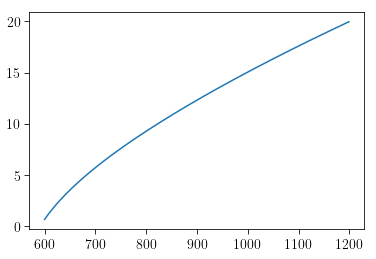

In [6]:
plt.plot(depthArr,(np.array(pol)))
# plt.xlim(600,650)

# Compare to real data

# Dec 24

In [37]:
SpiceCore0 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh0_8_run_012559.pkl")
SpiceCore0 = SpiceCore0.loc[(SpiceCore0.theta_reco>=90) & (SpiceCore0.power_H>0) & (SpiceCore0.power_V>0)]
SpiceCore0 = SpiceCore0.drop(columns=['Omega_reco'])

SpiceCore1 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh1_9_run_012559.pkl")
SpiceCore1 = SpiceCore1.loc[(SpiceCore1.theta_reco>=90) & (SpiceCore1.power_H>0) & (SpiceCore1.power_V>0)]
SpiceCore1 = SpiceCore1.drop(columns=['Omega_reco'])

SpiceCore2 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh2_10_run_012559.pkl")
SpiceCore2 = SpiceCore2.loc[(SpiceCore2.theta_reco>=90) & (SpiceCore2.power_H>0) & (SpiceCore2.power_V>0)]
SpiceCore2 = SpiceCore2.drop(columns=['Omega_reco'])

SpiceCore3 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh3_11_run_012559.pkl")
SpiceCore3 = SpiceCore3.loc[(SpiceCore3.theta_reco>=90) & (SpiceCore3.power_H>0) & (SpiceCore3.power_V>0)]
SpiceCore3 = SpiceCore3.drop(columns=['Omega_reco'])

SpiceCore4 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh4_12_run_012559.pkl")
SpiceCore4 = SpiceCore4.loc[(SpiceCore4.theta_reco>=90) & (SpiceCore4.power_H>0) & (SpiceCore4.power_V>0)]
SpiceCore4 = SpiceCore4.drop(columns=['Omega_reco'])

SpiceCore5 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh5_13_run_012559.pkl")
SpiceCore5 = SpiceCore5.loc[(SpiceCore5.theta_reco>=90) & (SpiceCore5.power_H>0) & (SpiceCore5.power_V>0)]
SpiceCore5 = SpiceCore5.drop(columns=['Omega_reco'])

SpiceCore6 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh6_14_run_012559.pkl")
SpiceCore6 = SpiceCore6.loc[(SpiceCore6.theta_reco>=90) & (SpiceCore6.power_H>0) & (SpiceCore6.power_V>0)]
SpiceCore6 = SpiceCore6.drop(columns=['Omega_reco']);

In [38]:
depth_1224 = pd.read_csv("./plots/SpiceCorePolReco/A2_1224Depth.txt")
time = pd.to_datetime(depth_1224.NZ_Time)
# time = time.reindex(time)
# time = time.tz_localize('NZ').tz_convert("UTC")
time.head()
newTime = time.apply(lambda dt: dt.replace(day=24, month = 12, year = 2018))
# newTime#Still in NZ local time. Need to translate to UTC
df = pd.DataFrame(1, index=newTime, columns=['X'])
import pytz
nz = pytz.timezone('NZ')
utc = pytz.timezone('UTC')
df.index = df.index.tz_localize(nz).tz_convert(utc)
unixTimeDepth = (df.index - pd.Timestamp("1970-01-01").tz_localize(utc)) // pd.Timedelta('1s')#This is unix time 

In [39]:
f = scipy.interpolate.interp1d(unixTimeDepth, depth_1224.depth,bounds_error=False, fill_value=0.)
SpiceCore2ForInterp = SpiceCore2.loc[(SpiceCore2.unixtime>min(SpiceCore2.unixtime)) & (SpiceCore2.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore2ForInterp.unixtime)
SpiceCore2ForInterp["interp_depth"] = interp_depth

In [40]:
SpiceCore0ForInterp = SpiceCore0.loc[(SpiceCore0.unixtime>min(SpiceCore0.unixtime)) & (SpiceCore0.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore0ForInterp.unixtime)
SpiceCore0ForInterp["interp_depth"] = interp_depth

SpiceCore1ForInterp = SpiceCore1.loc[(SpiceCore1.unixtime>min(SpiceCore1.unixtime)) & (SpiceCore1.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore1ForInterp.unixtime)
SpiceCore1ForInterp["interp_depth"] = interp_depth

SpiceCore2ForInterp = SpiceCore2.loc[(SpiceCore2.unixtime>min(SpiceCore2.unixtime)) & (SpiceCore2.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore2ForInterp.unixtime)
SpiceCore2ForInterp["interp_depth"] = interp_depth

SpiceCore3ForInterp = SpiceCore3.loc[(SpiceCore3.unixtime>min(SpiceCore3.unixtime)) & (SpiceCore3.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore3ForInterp.unixtime)
SpiceCore3ForInterp["interp_depth"] = interp_depth

SpiceCore4ForInterp = SpiceCore4.loc[(SpiceCore4.unixtime>min(SpiceCore4.unixtime)) & (SpiceCore4.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore4ForInterp.unixtime)
SpiceCore4ForInterp["interp_depth"] = interp_depth

SpiceCore5ForInterp = SpiceCore5.loc[(SpiceCore5.unixtime>min(SpiceCore5.unixtime)) & (SpiceCore5.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore5ForInterp.unixtime)
SpiceCore5ForInterp["interp_depth"] = interp_depth

SpiceCore6ForInterp = SpiceCore6.loc[(SpiceCore6.unixtime>min(SpiceCore6.unixtime)) & (SpiceCore6.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore6ForInterp.unixtime)
SpiceCore6ForInterp["interp_depth"] = interp_depth

In [41]:
# SpiceCore0ForInterp_limited = 0
SpiceCore0ForInterp = SpiceCore0ForInterp.loc[(SpiceCore0ForInterp.interp_depth>600) & (SpiceCore0ForInterp.interp_depth<1000)]
SpiceCore1ForInterp = SpiceCore1ForInterp.loc[(SpiceCore1ForInterp.interp_depth>600) & (SpiceCore1ForInterp.interp_depth<1000)]
SpiceCore2ForInterp = SpiceCore2ForInterp.loc[(SpiceCore2ForInterp.interp_depth>600) & (SpiceCore2ForInterp.interp_depth<1000)]
SpiceCore3ForInterp = SpiceCore3ForInterp.loc[(SpiceCore3ForInterp.interp_depth>600) & (SpiceCore3ForInterp.interp_depth<1000)]
SpiceCore4ForInterp = SpiceCore4ForInterp.loc[(SpiceCore4ForInterp.interp_depth>600) & (SpiceCore4ForInterp.interp_depth<1000)]
SpiceCore5ForInterp = SpiceCore5ForInterp.loc[(SpiceCore5ForInterp.interp_depth>600) & (SpiceCore5ForInterp.interp_depth<1000)]
SpiceCore6ForInterp = SpiceCore6ForInterp.loc[(SpiceCore6ForInterp.interp_depth>600) & (SpiceCore6ForInterp.interp_depth<1000)]


In [42]:

depthArr0 = []
pol0 = []
launchAng0 = []
recAng0 = []

depthArr1 = []
pol1 = []
launchAng1 = []
recAng1 = []

depthArr2 = []
pol2 = []
launchAng2 = []
recAng2 = []

depthArr3 = []
pol3 = []
launchAng3 = []
recAng3 = []

depthArr4 = []
pol4 = []
launchAng4 = []
recAng4 = []

depthArr5 = []
pol5 = []
launchAng5 = []
recAng5 = []

depthArr6 = []
pol6 = []
launchAng6 = []
recAng6 = []

for i in SpiceCore0ForInterp.itertuples():
    depthArr0.append(i.interp_depth)
    tracerArray = estimatePolRayTracer(i.interp_depth)
    pol0.append(abs(tracerArray[0]))
    launchAng0.append((tracerArray[1]))
    recAng0.append((tracerArray[2]))

for i in SpiceCore1ForInterp.itertuples():
    depthArr1.append(i.interp_depth)
    tracerArray = estimatePolRayTracer(i.interp_depth)
    pol1.append(abs(tracerArray[0]))
    launchAng1.append((tracerArray[1]))
    recAng1.append((tracerArray[2]))

for i in SpiceCore2ForInterp.itertuples():
    depthArr2.append(i.interp_depth)
    tracerArray = estimatePolRayTracer(i.interp_depth)
    pol2.append(abs(tracerArray[0]))
    launchAng2.append((tracerArray[1]))
    recAng2.append((tracerArray[2]))

for i in SpiceCore3ForInterp.itertuples():
    depthArr3.append(i.interp_depth)
    tracerArray = estimatePolRayTracer(i.interp_depth)
    pol3.append(abs(tracerArray[0]))
    launchAng3.append((tracerArray[1]))
    recAng3.append((tracerArray[2]))

for i in SpiceCore4ForInterp.itertuples():
    depthArr4.append(i.interp_depth)
    tracerArray = estimatePolRayTracer(i.interp_depth)
    pol4.append(abs(tracerArray[0]))
    launchAng4.append((tracerArray[1]))
    recAng4.append((tracerArray[2]))

for i in SpiceCore5ForInterp.itertuples():
    depthArr5.append(i.interp_depth)
    tracerArray = estimatePolRayTracer(i.interp_depth)
    pol5.append(abs(tracerArray[0]))
    launchAng5.append((tracerArray[1]))
    recAng5.append((tracerArray[2]))

for i in SpiceCore6ForInterp.itertuples():
    depthArr6.append(i.interp_depth)
    tracerArray = estimatePolRayTracer(i.interp_depth)
    pol6.append(abs(tracerArray[0]))
    launchAng6.append((tracerArray[1]))
    recAng6.append((tracerArray[2]))


In [43]:
SpiceCore0ForInterp["Omega_true"] = pol0
SpiceCore1ForInterp["Omega_true"] = pol1
SpiceCore2ForInterp["Omega_true"] = pol2
SpiceCore3ForInterp["Omega_true"] = pol3
SpiceCore4ForInterp["Omega_true"] = pol4
SpiceCore5ForInterp["Omega_true"] = pol5
SpiceCore6ForInterp["Omega_true"] = pol6

SpiceCore0ForInterp["launchAng"] = launchAng0
SpiceCore1ForInterp["launchAng"] = launchAng1
SpiceCore2ForInterp["launchAng"] = launchAng2
SpiceCore3ForInterp["launchAng"] = launchAng3
SpiceCore4ForInterp["launchAng"] = launchAng4
SpiceCore5ForInterp["launchAng"] = launchAng5
SpiceCore6ForInterp["launchAng"] = launchAng6

SpiceCore0ForInterp["recAng"] = recAng0
SpiceCore1ForInterp["recAng"] = recAng1
SpiceCore2ForInterp["recAng"] = recAng2
SpiceCore3ForInterp["recAng"] = recAng3
SpiceCore4ForInterp["recAng"] = recAng4
SpiceCore5ForInterp["recAng"] = recAng5
SpiceCore6ForInterp["recAng"] = recAng6

In [44]:
X_pol = 0.

In [45]:
def getPsi(theta, phi, R):
    theta = np.radians(theta)-90
    phi = np.radians(phi)
    numerator = np.cos(theta)*np.sin(phi)+R*np.cos(phi)
    denominator = np.cos(theta)*np.cos(phi)-R*np.sin(phi)
    
    return np.degrees(np.arctan(R))

In [46]:
SpiceCore0ForInterp["R"] = np.sqrt((SpiceCore0ForInterp.power_H-SpiceCore0ForInterp.powerH_noise)/(SpiceCore0ForInterp.power_V-SpiceCore0ForInterp.powerV_noise))
SpiceCore0ForInterp["sign"] = np.sign((SpiceCore0ForInterp.power_H-SpiceCore0ForInterp.powerH_noise)/(SpiceCore0ForInterp.power_V-SpiceCore0ForInterp.powerV_noise))
SpiceCore0ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore0ForInterp.recAng))/np.sqrt(1+SpiceCore0ForInterp.R**2)))
SpiceCore0ForInterp["R2"] = np.sqrt(abs(SpiceCore0ForInterp.power_H-SpiceCore0ForInterp.powerH_noise)/(SpiceCore0ForInterp.power_V-SpiceCore0ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore0ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore0ForInterp.recAng))/np.sqrt(1+SpiceCore0ForInterp.sign*SpiceCore0ForInterp.R2**2)))
SpiceCore0ForInterp["Psi"] = getPsi(SpiceCore0ForInterp.recAng, 255.5, SpiceCore0ForInterp.R)

SpiceCore1ForInterp["R"] = np.sqrt((SpiceCore1ForInterp.power_H-SpiceCore1ForInterp.powerH_noise)/(SpiceCore1ForInterp.power_V-SpiceCore1ForInterp.powerV_noise))
SpiceCore1ForInterp["sign"] = np.sign((SpiceCore1ForInterp.power_H-SpiceCore1ForInterp.powerH_noise)/(SpiceCore1ForInterp.power_V-SpiceCore1ForInterp.powerV_noise))
SpiceCore1ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore1ForInterp.recAng))/np.sqrt(1+SpiceCore1ForInterp.R**2)))
SpiceCore1ForInterp["R2"] = np.sqrt(abs(SpiceCore1ForInterp.power_H-SpiceCore1ForInterp.powerH_noise)/(SpiceCore1ForInterp.power_V-SpiceCore1ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore1ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore1ForInterp.recAng))/np.sqrt(1+SpiceCore1ForInterp.sign*SpiceCore1ForInterp.R2**2)))
SpiceCore1ForInterp["Psi"] = getPsi(SpiceCore1ForInterp.recAng, 255.5, SpiceCore1ForInterp.R)

SpiceCore2ForInterp["R"] = np.sqrt((SpiceCore2ForInterp.power_H-SpiceCore2ForInterp.powerH_noise)/(SpiceCore2ForInterp.power_V-SpiceCore2ForInterp.powerV_noise))
SpiceCore2ForInterp["sign"] = np.sign((SpiceCore2ForInterp.power_H-SpiceCore2ForInterp.powerH_noise)/(SpiceCore2ForInterp.power_V-SpiceCore2ForInterp.powerV_noise))
SpiceCore2ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore2ForInterp.recAng))/np.sqrt(1+SpiceCore2ForInterp.R**2)))
SpiceCore2ForInterp["R2"] = np.sqrt(abs(SpiceCore2ForInterp.power_H-SpiceCore2ForInterp.powerH_noise)/(SpiceCore2ForInterp.power_V-SpiceCore2ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore2ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore2ForInterp.recAng))/np.sqrt(1+SpiceCore2ForInterp.sign*SpiceCore2ForInterp.R2**2)))
SpiceCore2ForInterp["Psi"] = getPsi(SpiceCore2ForInterp.recAng, 255.5, SpiceCore2ForInterp.R)

SpiceCore3ForInterp["R"] = np.sqrt((SpiceCore3ForInterp.power_H-SpiceCore3ForInterp.powerH_noise)/(SpiceCore3ForInterp.power_V-SpiceCore3ForInterp.powerV_noise))
SpiceCore3ForInterp["sign"] = np.sign((SpiceCore3ForInterp.power_H-SpiceCore3ForInterp.powerH_noise)/(SpiceCore3ForInterp.power_V-SpiceCore3ForInterp.powerV_noise))
SpiceCore3ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore3ForInterp.recAng))/np.sqrt(1+SpiceCore3ForInterp.R**2)))
SpiceCore3ForInterp["R2"] = np.sqrt(abs(SpiceCore3ForInterp.power_H-SpiceCore3ForInterp.powerH_noise)/(SpiceCore3ForInterp.power_V-SpiceCore3ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore3ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore3ForInterp.recAng))/np.sqrt(1+SpiceCore3ForInterp.sign*SpiceCore3ForInterp.R2**2)))
SpiceCore3ForInterp["Psi"] = getPsi(SpiceCore3ForInterp.recAng, 255.5, SpiceCore3ForInterp.R)

SpiceCore4ForInterp["R"] = np.sqrt((SpiceCore4ForInterp.power_H-SpiceCore4ForInterp.powerH_noise)/(SpiceCore4ForInterp.power_V-SpiceCore4ForInterp.powerV_noise))
SpiceCore4ForInterp["sign"] = np.sign((SpiceCore4ForInterp.power_H-SpiceCore4ForInterp.powerH_noise)/(SpiceCore4ForInterp.power_V-SpiceCore4ForInterp.powerV_noise))
SpiceCore4ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore4ForInterp.recAng))/np.sqrt(1+SpiceCore4ForInterp.R**2)))
SpiceCore4ForInterp["R2"] = np.sqrt(abs(SpiceCore4ForInterp.power_H-SpiceCore4ForInterp.powerH_noise)/(SpiceCore4ForInterp.power_V-SpiceCore4ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore4ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore4ForInterp.recAng))/np.sqrt(1+SpiceCore4ForInterp.sign*SpiceCore4ForInterp.R2**2)))
SpiceCore4ForInterp["Psi"] = getPsi(SpiceCore4ForInterp.recAng, 255.5, SpiceCore4ForInterp.R)

SpiceCore5ForInterp["R"] = np.sqrt((SpiceCore5ForInterp.power_H-SpiceCore5ForInterp.powerH_noise)/(SpiceCore5ForInterp.power_V-SpiceCore5ForInterp.powerV_noise))
SpiceCore5ForInterp["sign"] = np.sign((SpiceCore5ForInterp.power_H-SpiceCore5ForInterp.powerH_noise)/(SpiceCore5ForInterp.power_V-SpiceCore5ForInterp.powerV_noise))
SpiceCore5ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore5ForInterp.recAng))/np.sqrt(1+SpiceCore5ForInterp.R**2)))
SpiceCore5ForInterp["R2"] = np.sqrt(abs(SpiceCore5ForInterp.power_H-SpiceCore5ForInterp.powerH_noise)/(SpiceCore5ForInterp.power_V-SpiceCore5ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore5ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore5ForInterp.recAng))/np.sqrt(1+SpiceCore5ForInterp.sign*SpiceCore5ForInterp.R2**2)))
SpiceCore5ForInterp["Psi"] = getPsi(SpiceCore5ForInterp.recAng, 255.5, SpiceCore5ForInterp.R)

SpiceCore6ForInterp["R"] = np.sqrt((SpiceCore6ForInterp.power_H-SpiceCore6ForInterp.powerH_noise)/(SpiceCore6ForInterp.power_V-SpiceCore6ForInterp.powerV_noise))
SpiceCore6ForInterp["sign"] = np.sign((SpiceCore6ForInterp.power_H-SpiceCore6ForInterp.powerH_noise)/(SpiceCore6ForInterp.power_V-SpiceCore6ForInterp.powerV_noise))
SpiceCore6ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore6ForInterp.recAng))/np.sqrt(1+SpiceCore6ForInterp.R**2)))
SpiceCore6ForInterp["R2"] = np.sqrt(abs(SpiceCore6ForInterp.power_H-SpiceCore6ForInterp.powerH_noise)/(SpiceCore6ForInterp.power_V-SpiceCore6ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore6ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore6ForInterp.recAng))/np.sqrt(1+SpiceCore6ForInterp.sign*SpiceCore6ForInterp.R2**2)))
SpiceCore6ForInterp["Psi"] = getPsi(SpiceCore6ForInterp.recAng, 255.5, SpiceCore6ForInterp.R)

SpiceCore0ForInterp = SpiceCore0ForInterp.dropna()
SpiceCore1ForInterp = SpiceCore1ForInterp.dropna()
SpiceCore2ForInterp = SpiceCore2ForInterp.dropna()
SpiceCore3ForInterp = SpiceCore3ForInterp.dropna()
SpiceCore4ForInterp = SpiceCore4ForInterp.dropna()
SpiceCore5ForInterp = SpiceCore5ForInterp.dropna()
SpiceCore6ForInterp = SpiceCore6ForInterp.dropna()

No handles with labels found to put in legend.


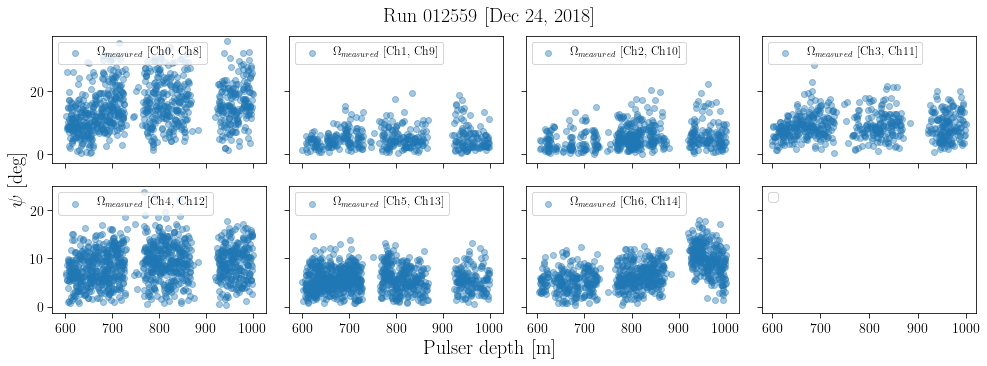

In [47]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()
axs[0].scatter(SpiceCore0ForInterp.interp_depth, SpiceCore0ForInterp.Psi, alpha = 0.4, label = "$\Omega_{measured}$ [Ch0, Ch8]")
axs[1].scatter(SpiceCore1ForInterp.interp_depth, SpiceCore1ForInterp.Psi, alpha = 0.4, label = "$\Omega_{measured}$ [Ch1, Ch9]")
axs[2].scatter(SpiceCore2ForInterp.interp_depth, SpiceCore2ForInterp.Psi, alpha = 0.4, label = "$\Omega_{measured}$ [Ch2, Ch10]")
axs[3].scatter(SpiceCore3ForInterp.interp_depth, SpiceCore3ForInterp.Psi, alpha = 0.4, label = "$\Omega_{measured}$ [Ch3, Ch11]")
axs[4].scatter(SpiceCore4ForInterp.interp_depth, SpiceCore4ForInterp.Psi, alpha = 0.4, label = "$\Omega_{measured}$ [Ch4, Ch12]")
axs[5].scatter(SpiceCore5ForInterp.interp_depth, SpiceCore5ForInterp.Psi, alpha = 0.4, label = "$\Omega_{measured}$ [Ch5, Ch13]")
axs[6].scatter(SpiceCore6ForInterp.interp_depth, SpiceCore6ForInterp.Psi, alpha = 0.4, label = "$\Omega_{measured}$ [Ch6, Ch14]")

# axs[6].set_xlabel("unixTime")
fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20)
fig.text(0.03, 0.5, '$\psi$ [deg]', ha='center', va='center', rotation='vertical', fontsize=20)

for ax in axs:
#     ax.set_xlim(350,1200)
#     ax.set_ylim(0,40)
    ax.set(xlabel="", ylabel = "")
#     ax.plot(depthArr,np.array(pol),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")


    ax.legend(loc="upper left")

plt.suptitle("Run 012559 [Dec 24, 2018]", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
# plt.savefig(my_path_plots+'/SpiceCorePolReco/SpiceCorePsiScatter_run012559.png', dpi=250)


## Scatter

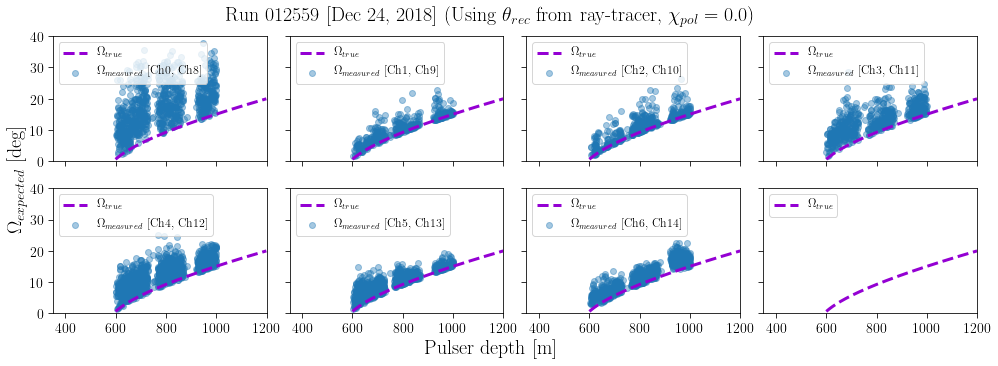

In [48]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()
axs[0].scatter(SpiceCore0ForInterp.interp_depth, SpiceCore0ForInterp.Omega_reco2, alpha = 0.4, label = "$\Omega_{measured}$ [Ch0, Ch8]")
axs[1].scatter(SpiceCore1ForInterp.interp_depth, SpiceCore1ForInterp.Omega_reco2, alpha = 0.4, label = "$\Omega_{measured}$ [Ch1, Ch9]")
axs[2].scatter(SpiceCore2ForInterp.interp_depth, SpiceCore2ForInterp.Omega_reco2, alpha = 0.4, label = "$\Omega_{measured}$ [Ch2, Ch10]")
axs[3].scatter(SpiceCore3ForInterp.interp_depth, SpiceCore3ForInterp.Omega_reco2, alpha = 0.4, label = "$\Omega_{measured}$ [Ch3, Ch11]")
axs[4].scatter(SpiceCore4ForInterp.interp_depth, SpiceCore4ForInterp.Omega_reco2, alpha = 0.4, label = "$\Omega_{measured}$ [Ch4, Ch12]")
axs[5].scatter(SpiceCore5ForInterp.interp_depth, SpiceCore5ForInterp.Omega_reco2, alpha = 0.4, label = "$\Omega_{measured}$ [Ch5, Ch13]")
axs[6].scatter(SpiceCore6ForInterp.interp_depth, SpiceCore6ForInterp.Omega_reco2, alpha = 0.4, label = "$\Omega_{measured}$ [Ch6, Ch14]")

# axs[6].set_xlabel("unixTime")
fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20)
fig.text(0.03, 0.5, '$\Omega_{expected}$ [deg]', ha='center', va='center', rotation='vertical', fontsize=20)

for ax in axs:
#     ax.set_xlabel("a")
    ax.set_xlim(350,1200)
    ax.set_ylim(0,40)
    ax.set(xlabel="", ylabel = "")
    ax.plot(depthArr,np.array(pol),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")


    ax.legend(loc="upper left")

plt.suptitle("Run 012559 [Dec 24, 2018] (Using $\\theta_{rec}$ from ray-tracer, $\chi_{pol} = %0.1f$)"%X_pol, fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
# plt.savefig(my_path_plots+'/SpiceCorePolReco/NewSpiceCoreScatter_run012559_chi_0.1.png', dpi=250)


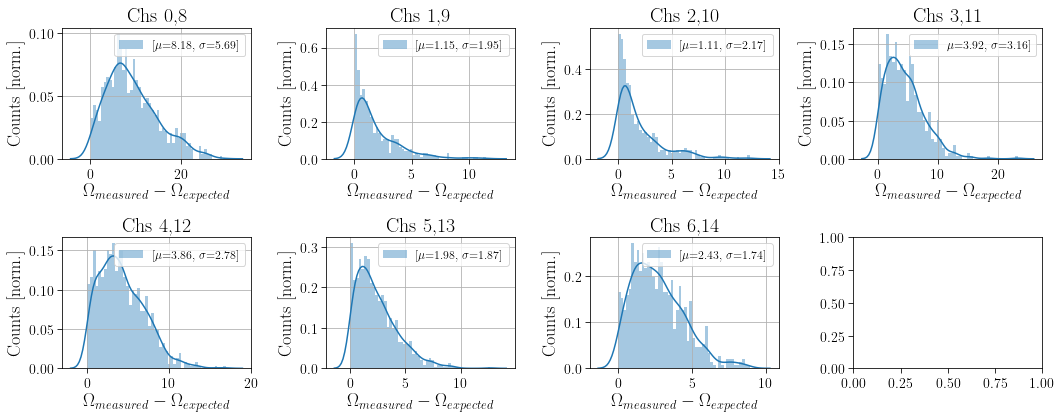

In [49]:
fig, ax = plt.subplots(2, 4, figsize=(15,6))
axs = ax.ravel()
delta = -1*(SpiceCore0ForInterp.Omega_true-SpiceCore0ForInterp.Omega_reco3)
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[0]);
axs[0].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[0].set_ylabel("Counts [norm.]")
axs[0].legend()
axs[0].grid()
axs[0].title.set_text("Chs 0,8")
# plt.title("$\Delta\Omega$ for SpiceCore events using a single channel pair")

delta = -1*(SpiceCore1ForInterp.Omega_true-SpiceCore1ForInterp.Omega_reco3)
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[1]);
axs[1].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[1].set_ylabel("Counts [norm.]")
axs[1].legend()
axs[1].grid()
axs[1].title.set_text("Chs 1,9")

delta = -1*(SpiceCore2ForInterp.Omega_true-SpiceCore2ForInterp.Omega_reco3)
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[2]);
axs[2].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[2].set_ylabel("Counts [norm.]")
axs[2].legend()
axs[2].grid()
axs[2].title.set_text("Chs 2,10")

delta = -1*(SpiceCore3ForInterp.Omega_true-SpiceCore3ForInterp.Omega_reco3)
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[3]);
axs[3].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[3].set_ylabel("Counts [norm.]")
axs[3].legend()
axs[3].grid()
axs[3].title.set_text("Chs 3,11")

delta = -1*(SpiceCore4ForInterp.Omega_true-SpiceCore4ForInterp.Omega_reco3)
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[4]);
axs[4].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[4].set_ylabel("Counts [norm.]")
axs[4].legend()
axs[4].grid()
axs[4].title.set_text("Chs 4,12")

delta = -1*(SpiceCore5ForInterp.Omega_true-SpiceCore5ForInterp.Omega_reco3)
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[5]);
axs[5].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[5].set_ylabel("Counts [norm.]")
axs[5].legend()
axs[5].grid()
axs[5].title.set_text("Chs 5,13")

delta = -1*(SpiceCore6ForInterp.Omega_true-SpiceCore6ForInterp.Omega_reco3)
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[6]);
axs[6].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[6].set_ylabel("Counts [norm.]")
axs[6].legend()
axs[6].grid()
axs[6].title.set_text("Chs 6,14")

plt.tight_layout()
# plt.savefig(my_path_plots+'/SpiceCorePolReco/deltaDist_run012559.png', dpi=250)

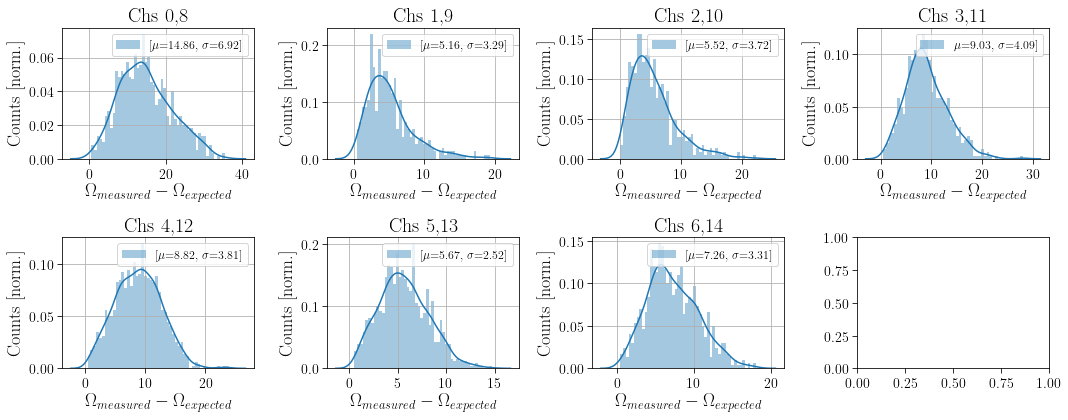

In [50]:
fig, ax = plt.subplots(2, 4, figsize=(15,6))
axs = ax.ravel()
delta = (SpiceCore0ForInterp.Psi)
delta_mean= np.mean(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[0]);
axs[0].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[0].set_ylabel("Counts [norm.]")
axs[0].legend()
axs[0].grid()
axs[0].title.set_text("Chs 0,8")
# plt.title("$\Delta\Omega$ for SpiceCore events using a single channel pair")

delta = (SpiceCore1ForInterp.Psi)
delta_mean= np.mean(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[1]);
axs[1].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[1].set_ylabel("Counts [norm.]")
axs[1].legend()
axs[1].grid()
axs[1].title.set_text("Chs 1,9")

delta = (SpiceCore2ForInterp.Psi)
delta_mean= np.mean(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[2]);
axs[2].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[2].set_ylabel("Counts [norm.]")
axs[2].legend()
axs[2].grid()
axs[2].title.set_text("Chs 2,10")

delta = (SpiceCore3ForInterp.Psi)
delta_mean= np.mean(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[3]);
axs[3].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[3].set_ylabel("Counts [norm.]")
axs[3].legend()
axs[3].grid()
axs[3].title.set_text("Chs 3,11")

delta = (SpiceCore4ForInterp.Psi)
delta_mean= np.mean(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[4]);
axs[4].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[4].set_ylabel("Counts [norm.]")
axs[4].legend()
axs[4].grid()
axs[4].title.set_text("Chs 4,12")

delta = (SpiceCore5ForInterp.Psi)
delta_mean= np.mean(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[5]);
axs[5].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[5].set_ylabel("Counts [norm.]")
axs[5].legend()
axs[5].grid()
axs[5].title.set_text("Chs 5,13")

delta = (SpiceCore6ForInterp.Psi)
delta_mean= np.mean(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[6]);
axs[6].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[6].set_ylabel("Counts [norm.]")
axs[6].legend()
axs[6].grid()
axs[6].title.set_text("Chs 6,14")

plt.tight_layout()
# plt.savefig(my_path_plots+'/SpiceCorePolReco/deltaDist_run012559.png', dpi=250)